# Overview

In this notebook we present code for the main results on in-distribution data of the paper.


In [1]:
from typing import Tuple

import numpy as np
from scipy.linalg import lstsq
from scipy import linalg
from tqdm.notebook import tqdm
%matplotlib inline
import matplotlib.pyplot as plt

# import helper function
from utils import get_eigenvector_product, get_eigenvalue_dist, get_marchenko_pastur, get_cumulative_marchenko_pastur

# Data generator: spiked covariance model

In [2]:
def data_spikedcov(n_data_train: int = 200, n_data_test: int = 200,
                   n_features: int = 50,
                   lambda_spikes: np.ndarray = None,
                   sigma_y: float = 0.1, snr_x: float = 1, r_theta: float = 1,
                   ) -> Tuple[Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray], dict]:
    # check input
    if lambda_spikes is None:
        raise ValueError('lambda_spikes is None and must be defined')
    n_spikes = len(lambda_spikes)

    #########################################
    # sample latent space z
    #########################################
    # covariance source
    cov_z = np.diag(lambda_spikes)
    # mean
    mean_z = np.zeros(n_spikes)
    # sample zS and zT
    z_train = np.random.multivariate_normal(mean_z, cov_z, n_data_train)
    z_test = np.random.multivariate_normal(mean_z, cov_z, n_data_test)

    #########################################
    # features x
    #########################################
    r_w = np.sqrt(snr_x * n_features / np.trace(cov_z))
    W = np.eye(n_features, n_spikes)
    x_train = z_train @ W.T * r_w + 1 * np.random.randn(n_data_train, n_features)
    x_test = z_test @ W.T * r_w + 1 * np.random.randn(n_data_test, n_features)

    # covariances
    cov_x = np.eye(n_features)
    cov_x[:n_spikes, :n_spikes] += cov_z * r_w ** 2

    #########################################
    # observations y
    #########################################
    c_theta = r_theta / np.sqrt(np.trace(cov_z))
    theta = c_theta * np.ones((n_spikes, 1))
    y_train = z_train @ theta + sigma_y * np.random.randn(n_data_train, 1)
    y_test = z_test @ theta + sigma_y * np.random.randn(n_data_test, 1)

    #########################################
    # compute direct model equivalent
    #########################################
    # equivalent of x->y instead of z->y, z->x
    beta = np.linalg.pinv(np.eye(n_features) + r_w ** 2 * W @ cov_z @ W.T) @ W @ cov_z @ theta * r_w
    sigma2_nu = sigma_y ** 2 + theta.T @ np.linalg.pinv(np.eye(n_spikes) + r_w ** 2 * cov_z) @ cov_z @ theta

    #########################################
    # collect all parameters which I would need later
    #########################################
    parameters = dict()
    parameters['cov_z'] = cov_z
    parameters['cov_x'] = cov_x

    parameters['r_w'] = r_w
    parameters['r_theta'] = r_theta
    parameters['W'] = W
    parameters['theta'] = theta

    parameters['beta'] = beta
    parameters['sigma2_nu'] = sigma2_nu

    return (x_train, y_train, x_test, y_test), parameters

# Models

## a) PCR model

In [3]:
#########################################
# Simulation
#########################################
class ModelPca(object):
    def __init__(self, n_components):
        super(ModelPca, self).__init__()
        """
        This is a model of the form
        input x --[PCA]--> z --[Regression]--> output
        """
        # save to self
        self.n_components = n_components
        # allocation
        self.components = None
        self.beta_hat = None

    def fit(self, x_train, y_train):
        U, S = self.fit_encode(x_train)

        # pca transform (unnecessary since we do a more direct way to obtain beta_hat)
        # z = x_train @ self.components

        # get least squares solution by using pre-computed SVD
        self.beta_hat = np.diag(1. / S[:self.n_components]) @ (U[:, :self.n_components].T @ y_train)
        # self.beta_hat, _, _, _ = lstsq(z, y_train)

    def fit_encode(self, x_train):
        # pca fit
        U, S, Vt = linalg.svd(x_train, full_matrices=False)
        V = Vt.T
        self.components = V[:, :self.n_components]
        return U, S

    def fit_regression(self, x_train, y_train):
        # encode
        z = self.encode(x_train)
        # get least squares solution
        self.beta_hat, _, _, _ = lstsq(z, y_train)

    def encode(self, x):
        z = x @ self.components
        return z

    def predict(self, x_test):
        # transform to latent
        z = self.encode(x_test)

        # make prediction
        y_pred = z @ self.beta_hat

        return y_pred

    
#########################################
# Analytical solution
#########################################
class ModelPcaTheory(object):
    def __init__(self, cov_z, r_w, theta, sigma_y, n_spikes):
        super(ModelPcaTheory, self).__init__()
        self.cov_z = cov_z
        self.r_w = r_w
        self.theta = theta
        self.sigma_y = sigma_y
        self.n_spikes = n_spikes
        self.P_d = None

        self.sigma2_nu = self.compute_noise()

    def compute_noise(self):
        noise = self.sigma_y ** 2 + self.theta.T @ \
                np.linalg.pinv(np.eye(self.n_spikes) + self.r_w ** 2 * self.cov_z) @ self.cov_z @ self.theta
        return noise.item()

    def compute_bias(self, gamma, n_components, n_features):
        # defs for bias
        Lambda_d = self.cov_z * self.r_w ** 2 + np.eye(self.n_spikes)
        beta_bar = self.r_w * self.cov_z @ \
                   np.linalg.pinv(np.eye(self.n_spikes) + self.r_w ** 2 * self.cov_z) @ self.theta

        # bias
        if self.P_d is None:
            self.P_d = get_eigenvector_product(gamma=gamma,
                                               eigvals=np.diag(self.cov_z) * self.r_w ** 2 + 1.,
                                               n_components=n_components,
                                               n_features=n_features)
        temp = Lambda_d - \
               Lambda_d @ self.P_d - \
               self.P_d @ Lambda_d + \
               self.P_d + self.r_w ** 2 * self.P_d @ self.cov_z @ self.P_d
        bias = beta_bar.T @ temp @ beta_bar
        return bias.item()

    def compute_var(self, gamma, n_components, n_features, n_data_train):
        # part 1
        spikes_mu = get_eigenvalue_dist(gamma=gamma,
                                        eigvals=np.diag(self.cov_z) * self.r_w ** 2 + 1,
                                        n_data=None)
        if self.P_d is None:
            self.P_d = get_eigenvector_product(gamma=gamma,
                                               eigvals=np.diag(self.cov_z) * self.r_w ** 2 + 1.,
                                               n_components=n_components,
                                               n_features=n_features)
        temp = self.r_w ** 2 * np.sqrt(self.P_d) @ self.cov_z @ np.sqrt(self.P_d) + np.eye(self.n_spikes)
        temp = temp[:min(n_components, self.n_spikes), :min(n_components, self.n_spikes)]
        temp = temp * 1 / spikes_mu[:min(n_components, self.n_spikes)]
        var_trace = np.trace(temp)
        # part 2
        cond = 1 - max((n_components - self.n_spikes) / (n_features - self.n_spikes), 0)
        if cond < 1.0:
            n_eval_points = 1_000_000
            gamma_n, gamma_p = (1 - np.sqrt(gamma)) ** 2, (1 + np.sqrt(gamma)) ** 2
            x_mp = np.linspace(1e-10, gamma_p, n_eval_points)
            # cumulative marchenko pastur distribution
            mp_integrand = get_cumulative_marchenko_pastur(x_mp, gamma)
            # idx = np.argmin(np.abs(mp_integrand - cond))
            idx = np.where(mp_integrand > cond)[0][0]
            # integrate over mp * 1/x
            x_mp1 = np.linspace(x_mp[idx], gamma_p, n_eval_points)
            mp1 = get_marchenko_pastur(x_mp1, gamma)
            var_iso = np.trapz(mp1 * 1 / x_mp1, x_mp1)
        else:
            var_iso = 0
        # final variance
        var = self.sigma2_nu / n_data_train * (var_trace + (n_features - self.n_spikes) * var_iso)
        return var.item()

    def compute_risk(self, gamma, n_components, n_features, n_data_train):
        return self.compute_bias(gamma, n_components, n_features) + \
            self.compute_var(gamma, n_components, n_features, n_data_train) + \
            self.sigma2_nu

## b) Full regression model

In [4]:
#########################################
# Simulation
#########################################
class ModelDirect(object):
    def __init__(self):
        super(ModelDirect, self).__init__()
        """
        This is a simple regression model for comparison of the form
        input x --[Regression]--> output
        """

    def fit(self, x_train, y_train):
        # get least squares solution
        self.beta_hat, _, _, _ = lstsq(x_train, y_train)

    def predict(self, x_test):
        # make prediction
        y_pred = x_test @ self.beta_hat

        return y_pred

#########################################
# Analytical solution
#########################################
class ModelDirectTheory(ModelPcaTheory):
    def compute_bias(self, gamma, n_components, n_features):
        n_components = n_features
        if gamma < 1:
            return 0
        else:
            # defs for bias
            Lambda_d = self.cov_z * self.r_w ** 2 + np.eye(self.n_spikes)
            beta_bar = self.r_w * self.cov_z @ \
                       np.linalg.pinv(np.eye(self.n_spikes) + self.r_w ** 2 * self.cov_z) @ self.theta

            # bias
            if self.P_d is None:
                self.P_d = get_eigenvector_product(gamma=gamma,
                                                   eigvals=np.diag(self.cov_z) * self.r_w ** 2 + 1.,
                                                   n_components=n_components,
                                                   n_features=n_features)
            temp = Lambda_d - \
                   Lambda_d @ self.P_d - \
                   self.P_d @ Lambda_d + \
                   self.P_d + self.r_w ** 2 * self.P_d @ self.cov_z @ self.P_d
            bias = beta_bar.T @ temp @ beta_bar
            return bias.item()

# Risk on in-distribution data

This result corresponds to Figure 5.

For smoother averaged results increase mc_runs (in the paper we use 50). 

For smoother results over $\gamma$, increase gamma_num (in the paper we use 50).

In [5]:
# dataset options
n_data_train = 500
n_data_test = 500

n_spikes = 10
sigma_y = 0.1
snr_x = 1
r_theta = 1
alpha_l = 0.1

# model options
gamma_min, gamma_max, gamma_num = 0.3, 5, 20
gamma_list = np.logspace(np.log10(gamma_min), np.log10(gamma_max), gamma_num)
n_components = [-40, 8, 10, 50] # -40 corresponds to p-40
mc_runs = 15

## Run main loop

In [6]:
seed = 42

##############################
# Setup
##############################
# define spikes of data generator
lambda_spikes = np.exp(-alpha_l * np.linspace(0, 1, n_spikes))

# define risk
compute_risk = lambda y_, y_pred_: 1 / len(y_) * np.linalg.norm(y_ - y_pred_) ** 2

# define models to run
models = ['direct_theory', 'direct_sim'] + \
         [f'pca_theory_{c}' for c in n_components] + \
         [f'pca_sim_{c}' for c in n_components]
models_main = ['direct_theory', 'direct_sim', 'pca_theory', 'pca_sim',]

# allocation
risk_logs = dict()
for lg in models:
    risk_logs[lg] = np.zeros([mc_runs, gamma_num])

#########################################
# overparameterization loop
#########################################
# loop over averagings
for i_mc, mc in enumerate(range(mc_runs)):
    for i_gamma, gamma in enumerate(tqdm(gamma_list, desc='mc run {}/{}'.format(i_mc + 1, mc_runs), leave=True)):
        # compute number of features
        n_features = int(gamma * n_data_train)
        
        # n_components as subtraction of n_features (because of p-components)
        n_components_true = [int(gamma * n_data_train) + n_components if n_components < 1 else n_components for n_components in n_components]
        
        ######################################
        # generate data
        ######################################
        data = data_spikedcov(n_data_train=n_data_train, n_data_test=n_data_test,
                              n_features=n_features,
                              lambda_spikes=lambda_spikes,
                              sigma_y=sigma_y, snr_x=snr_x, r_theta=r_theta)
        (x_train, y_train, x_test, y_test), data_parameters = data
        
        ######################################
        # compute risk for each model
        ######################################
        # loop over all models to run
        for model in models_main:
            if model == 'direct_sim':
                # define model
                model_direct = ModelDirect()
                # fit model
                model_direct.fit(x_train, y_train)
                # predict
                y_pred = model_direct.predict(x_test)
                # compute risk
                risk_logs[model][i_mc, i_gamma] = compute_risk(y_test, y_pred)
            elif model == 'direct_theory':
                # define model
                model_direct_theory = ModelDirectTheory(cov_z=data_parameters['cov_z'],
                                                        r_w=data_parameters['r_w'],
                                                        theta=data_parameters['theta'],
                                                        sigma_y=sigma_y,
                                                        n_spikes=n_spikes)
                # compute noise
                noise = model_direct_theory.sigma2_nu
                # compute bias
                bias = model_direct_theory.compute_bias(gamma, n_features, n_features)
                # compute variance
                variance = model_direct_theory.compute_var(gamma, n_features, n_features, n_data_train)
                # compute risk
                risk_logs[model][i_mc, i_gamma] = bias + variance + noise
            elif model.startswith('pca_sim'):
                for i, c in enumerate(n_components_true):
                    # define model
                    model_pca = ModelPca(n_components=c)
                    # fit model
                    model_pca.fit(x_train, y_train)
                    # predict
                    y_pred = model_pca.predict(x_test)
                    # compute risk                    
                    risk_logs[f'{model}_{n_components[i]}'][i_mc, i_gamma] = compute_risk(y_test, y_pred)
            elif model.startswith('pca_theory'):
                for i, c in enumerate(n_components_true):
                    # define model
                    model_pca_theory = ModelPcaTheory(cov_z=data_parameters['cov_z'],
                                                      r_w=data_parameters['r_w'],
                                                      theta=data_parameters['theta'],
                                                      sigma_y=sigma_y,
                                                      n_spikes=n_spikes)
                    # compute noise
                    noise = model_pca_theory.sigma2_nu
                    # compute bias
                    bias = model_pca_theory.compute_bias(gamma, c, n_features)
                    # compute variance
                    variance = model_pca_theory.compute_var(gamma, c, n_features, n_data_train)
                    # compute risk
                    risk_logs[f'{model}_{n_components[i]}'][i_mc, i_gamma] = bias + variance + noise

mc run 1/15:   0%|          | 0/20 [00:00<?, ?it/s]

mc run 2/15:   0%|          | 0/20 [00:00<?, ?it/s]

mc run 3/15:   0%|          | 0/20 [00:00<?, ?it/s]

mc run 4/15:   0%|          | 0/20 [00:00<?, ?it/s]

mc run 5/15:   0%|          | 0/20 [00:00<?, ?it/s]

mc run 6/15:   0%|          | 0/20 [00:00<?, ?it/s]

mc run 7/15:   0%|          | 0/20 [00:00<?, ?it/s]

mc run 8/15:   0%|          | 0/20 [00:00<?, ?it/s]

mc run 9/15:   0%|          | 0/20 [00:00<?, ?it/s]

mc run 10/15:   0%|          | 0/20 [00:00<?, ?it/s]

mc run 11/15:   0%|          | 0/20 [00:00<?, ?it/s]

mc run 12/15:   0%|          | 0/20 [00:00<?, ?it/s]

mc run 13/15:   0%|          | 0/20 [00:00<?, ?it/s]

mc run 14/15:   0%|          | 0/20 [00:00<?, ?it/s]

mc run 15/15:   0%|          | 0/20 [00:00<?, ?it/s]

## Analysis of results

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


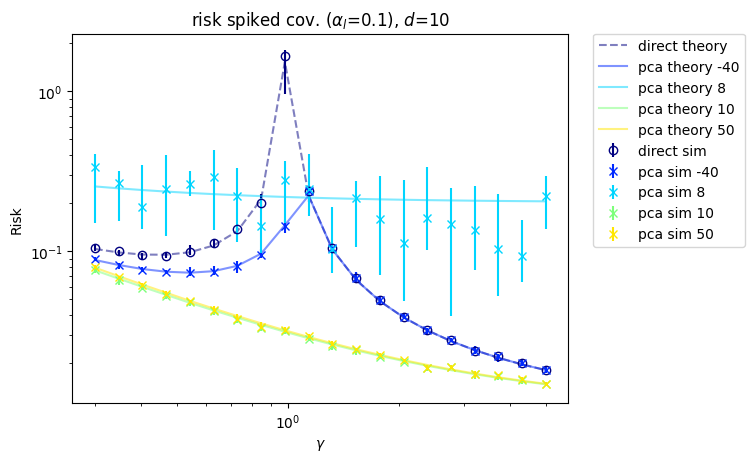

In [7]:
###############################
# average over mc runs
###############################
risk_logs_median = dict()
risk_logs_25quantile = dict()
risk_logs_75quantile = dict()
for lg in models:
    risk_logs_median[lg] = np.median(risk_logs[lg], axis=0)
    risk_logs_25quantile[lg] = np.quantile(risk_logs[lg], 0.25, axis=0)
    risk_logs_75quantile[lg] = np.quantile(risk_logs[lg], 0.75, axis=0)
    
###############################
# show results
###############################
fig, ax = plt.subplots(1, 1, figsize=(6.4, 4.8))

color_map = {}  # To store colors for each simulation/theory name
for key in risk_logs_median:
    # get same color for theory/simulation
    name = key.replace('_sim', '').replace('_theory', '')
    if name not in color_map:
        color_map[name] = plt.cm.jet(len(color_map) / (len(n_components) + 2))  # Assign color based on index
    color = color_map[name]
    marker = 'x' if 'pca' in key else 'o'
    
    # label
    label = key.split('_')[0]
    
    # plot stuff
    if '_sim' in key:
        yerr_low = risk_logs_median[key] - risk_logs_25quantile[key]
        yerr_high = risk_logs_75quantile[key] - risk_logs_median[key]
        ax.errorbar(gamma_list, 
                    risk_logs_median[key], 
                    yerr=(yerr_low, yerr_high), 
                    label=key.replace('_', ' '),
                    linestyle='None', marker=marker, markerfacecolor='None', color=color)
    else:
        linestyle = 'dashed' if label == 'direct' else 'solid'
        ax.plot(gamma_list, risk_logs_median[key], label=key.replace('_', ' '),
                linestyle=linestyle, alpha=0.5, color=color)

ax.set_xscale('log'), ax.set_yscale('log')
ax.set_xlabel(r'$\gamma$')
ax.set_ylabel('Risk')
ax.set_title(r'risk spiked cov. ($\alpha_l$={}), $d$={}'.format(alpha_l, n_spikes))
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
fig.show()